In [1]:
import pandas as pd
from pathlib import Path
from Bio import Seq
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import re
import seaborn as sns
import vcf
sns.set_style('whitegrid')
sns.set_palette('colorblind')
from collections import Counter

In [2]:
ss = pd.read_csv('20220101_MN01513_WGS114_DEC31SRI_CK_summary_valid_negative_pass_only.tsv', sep='\t')
ss['sample_annotated'] = ss['scorpio_call'].str.split().str.get(0) + ":" + ss['lineage'] + " (" + ss['sample'] + ")"
sample_name_annotation = ss.set_index('sample')['sample_annotated'].to_dict()

In [3]:
def parse_vcf_snpeff_record(record, sample):
    parsed_records = []
    for ix, alt in enumerate(record.ALT):
        parsed_alt = {}

        # get var only for that alt
        var_list = [ann for ann in record.INFO['ANN'] if ann.split('|')[0] == alt]
        #remove up/downstream/intergenic mutations
        var_list = [ann for ann in var_list if ann.split('|')[1] not in ['upstream_gene_variant', 
                                                                                 'downstream_gene_variant']]
        if len(var_list) > 1:
            print("var_list has multiple changes", var_list)
            assert False
        elif len(var_list) == 0:
            print("var_list has no annotation", var_list)
            assert False
        else:
            ann = var_list[0].split('|')
            parsed_alt['Mutation Effect'] = ann[1]
            parsed_alt['Mutation Gene'] = ann[3]
            parsed_alt['Nucleotide Mutation'] = ann[9]
        
            if ann[1] == 'intergenic_region':
                parsed_alt['Protein Mutation'] = f"No Protein Effect ({ann[9]})"
            elif ann[1] == 'synonymous_variant':
                parsed_alt['Protein Mutation'] = ann[3] + ": synonymous " + ann[10]
            else:
                parsed_alt['Protein Mutation'] = ann[3] + ":" + ann[10]

        parsed_alt['Sample'] = sample
        parsed_alt['Genome Position'] = record.POS
        parsed_alt['Allele Read Count'] = record.INFO['AO'][ix]
        parsed_alt['Total Read Count'] = record.INFO['DP']
        parsed_alt['% Reads Supporting Allele'] = record.INFO['VAF'][ix] * 100
    
    parsed_records.append(parsed_alt)
    return parsed_records


parsed_records = []
for vcf_fp in Path('variants').glob("*.vcf"):
    sample = str(vcf_fp).rstrip('.ann.vcf').lstrip('variants/')
    with open(vcf_fp) as fh:
        for record in vcf.Reader(fh):
            parsed_records.extend(parse_vcf_snpeff_record(record, sample))
            
variants = pd.DataFrame(parsed_records)
#variants['sample_ix'] = variants['Sample'].str.split('-').str.get(-1).astype(int)
variants = variants.sort_values(['Sample', 'Genome Position'], ascending=[True, True])
variants['Sample'] = variants['Sample'].apply(lambda x: sample_name_annotation[x])
#variants = variants.drop('sample_ix', axis=1)

# Variant Changes Over Time

In [4]:
def plot_allele_pres_absence(variants_subset, title, savepath, all_mutations=False):

    coverage_thresold = 50
    
    variant_order = variants_subset.sort_values("Genome Position")['Protein Mutation'].unique()
    sample_order = variants_subset['Sample'].unique()
    variant_presence_absence = pd.crosstab(variants_subset['Sample'], variants_subset['Protein Mutation'])
    variant_presence_absence = variant_presence_absence.loc[sample_order, variant_order].T

    variant_percentage_alleles = variants_subset[variants_subset['Protein Mutation'].isin(variant_presence_absence.index)]
    variant_percentage_alleles = variant_percentage_alleles.pivot('Sample', 'Protein Mutation', '% Reads Supporting Allele').fillna(0)
    variant_order = [x for x in variants_subset.sort_values('Genome Position')['Protein Mutation'].unique() if x in variant_percentage_alleles.columns]
    variant_percentage_alleles = variant_percentage_alleles.loc[sample_order, variant_order].T

    
    # drop any all >99% 
    if not all_mutations:
        all_high_coverage_variants = [var for var in variant_percentage_alleles.T if (variant_percentage_alleles.T[var] > 95).all() ]
        variant_percentage_alleles = variant_percentage_alleles.drop(all_high_coverage_variants)

    # low coverage mutations (possible dropout)
    low_coverage = variants_subset[variants_subset['Allele Read Count'] < coverage_thresold]['Protein Mutation'].unique()
                            
    #variant_percentage_alleles = variant_percentage_alleles.rename(index=possible_dropout)

    #return variant_percentage_alleles
    fig, ax = plt.subplots(figsize=(6,12))
    
    ax.set_title(title)
    sns.heatmap(variant_percentage_alleles, vmin=0, vmax=100, linewidths=.1, ax=ax, xticklabels=True, cmap="mako_r", yticklabels=True,
                cbar_kws={'label': '% Reads Supporting Allele'})
    ax.set_ylabel(f"Protein Mutation\n(Any Sample <{coverage_thresold}X Coverage in Red)")
    ax.set_xlabel(f"Samples\n(Original Genomes in Bold)")

    # colour OG and low coverage labels
    for label in ax.get_yticklabels():
        if label.get_text() in low_coverage:
            label.set_color('red')
            
     # colour OG and low coverage labels
    for label in ax.get_xticklabels():
        if "OG" in label.get_text():
            label.set_fontweight('bold')
    #return label
    #return fig, ax
    plt.savefig(savepath, dpi=300, bbox_inches='tight', facecolor='white', transparent=False)
    return variant_percentage_alleles

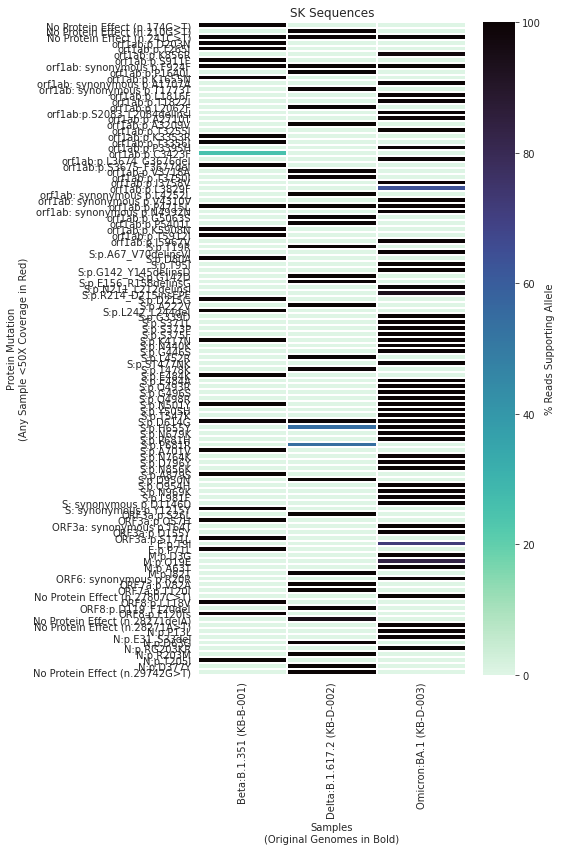

In [5]:
variant_percentage_alleles = plot_allele_pres_absence(variants, 'SK Sequences', "mutation_table.png", all_mutations=True)

In [6]:
variant_percentage_alleles = variant_percentage_alleles.applymap(lambda x: '{0:.1f}'.format(x))
variant_percentage_alleles = variant_percentage_alleles.astype(str).replace('0.0', '')
variant_percentage_alleles = variant_percentage_alleles.reset_index()
variant_percentage_alleles['Gene'] = variant_percentage_alleles['Protein Mutation'].str.split(':').str.get(0).replace({'orf1ab': 'ORF1ab'})
variant_percentage_alleles = variant_percentage_alleles[~variant_percentage_alleles['Protein Mutation'].str.contains('synonymous')]
variant_percentage_alleles = variant_percentage_alleles[~variant_percentage_alleles['Protein Mutation'].str.contains('No Protein Effect')]
variant_percentage_alleles['Variant (HGVS)'] = variant_percentage_alleles['Protein Mutation'].str.split(':').str.get(1)
variant_percentage_alleles = variant_percentage_alleles.drop('Protein Mutation', axis=1)
variant_percentage_alleles = variant_percentage_alleles.set_index(['Gene', "Variant (HGVS)"])
variant_percentage_alleles.columns.name=''
variant_percentage_alleles.to_csv('variant_percentage_read_support_protein_nonsynonymous_only.tsv', sep='\t')

In [37]:
spike_only = variant_percentage_alleles.reset_index()
spike_only = spike_only[spike_only['Gene'] == 'S'].drop('Gene', axis=1)
spike_only = spike_only.rename(columns={"Variant (HGVS)": "S Variants"}).set_index('S Variants')


In [51]:

d = dict(selector="th",
    props=[('text-align', 'center')])
spike_only = spike_only.style.set_properties(**{'width':'1em', 'text-align':'center'})\
        .set_table_styles([d])
dfi.export(spike_only, 'spike_mutation_table_styled.png', fontsize=50)
#dfi.export(spike_only, 'spike_mutation_table.png', fontsize=72)

AttributeError: 'Styler' object has no attribute 'style'

In [53]:
spike_only.export_png('spike_mutation_table_styled.png', fontsize=50)

In [35]:
#spike_only.columns  = [x.split(':')[0] for x in spike_only.columns]

In [48]:
spike_only

,Beta:B.1.351 (KB-B-001),Delta:B.1.617.2 (KB-D-002),Omicron:BA.1 (KB-D-003)
S Variants,,,
p.T19R,,99.9,
p.A67_V70delinsVI,,,100.0
p.D80A,100.0,,
p.T95I,,,99.9
p.G142_Y145delinsD,,,99.9
p.G142D,,100.0,
p.E156_R158delinsG,,100.0,
p.N211_L212delinsI,,,100.0
p.R214_D215insEPE,,,93.6


In [10]:
import dataframe_image as dfi
\

In [22]:
?dfi.export

## Get Contexualising Sequences for Phylogeny

Sticking with COG-UK and CDC data that is released via NCBI as well for ease.

Get a random sample top 300 lineages in Canada from COG-UK and CDC (a few are missing but enough to contexualise the results).

Using a GISAID + Nextstrain ncov-ingest formatted metadata (downloaded 2022-01-03)

In [80]:
metadata = pd.read_csv('metadata_2021-12-31_17-29.tsv.gz', sep='\t')
canada = metadata[metadata['country'] == 'Canada']
open_genomes = metadata[(metadata['submitting_lab'].str.contains("COG-UK")) | (metadata['submitting_lab'] == 'Centers for Disease Control and Prevention Division of Viral Diseases, Pathogen Discovery')]
top300_canada_lineages = canada['pango_lineage'].value_counts().head(300).index
open_genomes_in_top300_canada_lineages = open_genomes[open_genomes['pango_lineage'].isin(top300_canada_lineages)] 
random_sample_open_genomes = open_genomes_in_top300_canada_lineages.groupby('pango_lineage').sample(1)
reference_genomes = metadata[metadata['strain'].isin(['Wuhan/Hu-1/2019', 'Wuhan/WH01/2019'])]

/bioinf/anaconda3/envs/ncov-qc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [88]:
all_metadata = pd.concat([random_sample_open_genomes, reference_genomes])

In [90]:
all_metadata.to_csv('random_sample_canadian_lineages_from_CDC_cog.tsv', sep='\t')

In [118]:
keep_accs = all_metadata['strain'].unique()
seqs = []
with open('/home/fin/sequences.fasta') as fh:
    for line in tqdm(fh):
        if line.startswith('>'):
            save_seq = False
            nextstrain_acc = line.rstrip().lstrip('>hCoV-19/').split('|')[0]
            if nextstrain_acc in keep_accs:
                save_seq = True
                print(line)
                seqs.append(line)
        elif save_seq:
            seqs.append(line)
            
with open('phlyogeny/open_context_genomes.fasta', 'w') as fh:
    fh.write("".join(seqs))

0it [00:00, ?it/s]

>hCoV-19/England/LIVE-DDA6C4/2021|2021-01-10|2021-01-25

>hCoV-19/Scotland/QEUH-10672A4/2021|2021-01-17|2021-02-03

>hCoV-19/England/MILK-112E92B/2021|2021-01-21|2021-02-04

>hCoV-19/USA/MI-CDC-ASC210363938/2021|2021-10-14|2021-11-10

>hCoV-19/USA/CO-CDC-2-4194872/2020|2020-12-17|2021-04-24

>hCoV-19/USA/CO-CDC-2-4194788/2020|2020-12-17|2021-04-24

>hCoV-19/USA/OR-CDC-2-4195152/2020|2020-12-24|2021-04-24

>hCoV-19/USA/OR-CDC-2-4194772/2020|2020-12-17|2021-04-24

>hCoV-19/England/QEUH-A0B9C4/2020|2020-10-01|2020-10-27

>hCoV-19/England/ALDP-1B9F5EB/2021|2021-08-12|2021-08-20

>hCoV-19/England/CAMC-1179068/2021|2021-01-14|2021-02-15

>hCoV-19/USA/AR-CDC-2-4012868/2021|2021-02-02|2021-03-23

>hCoV-19/Wales/CAMC-13B7257/2021|2021-03-06|2021-03-24

>hCoV-19/England/CAMC-139C4DA/2021|2021-03-08|2021-03-24

>hCoV-19/USA/OH-CDC-QDX22758838/2021|2021-03-07|2021-03-24

>hCoV-19/England/MILK-2F07004/2021|2021-12-16|2021-12-24

>hCoV-19/England/BRBR-2C302B4/2021|2021-11-26|2021-12-05

>hCoV-19/USA

>hCoV-19/USA/IN-CDC-QDX30855991/2021|2021-11-05|2021-11-26

>hCoV-19/USA/IN-CDC-ASC210522403/2021|2021-11-05|2021-11-26

>hCoV-19/England/ALDP-CF159E/2020|2020-12-18|2021-01-08

>hCoV-19/USA/OH-CDC-ASC210429048/2021|2021-11-20|2021-12-15

>hCoV-19/England/MILK-2B73BD9/2021|2021-11-22|2021-11-29

>hCoV-19/USA/PA-CDC-STM-000035416/2021|2021-03-13|2021-04-02

>hCoV-19/England/MILK-2DF642C/2021|2021-12-09|2021-12-16

>hCoV-19/England/BRBR-2DFD391/2021|2021-12-09|2021-12-16

>hCoV-19/England/PHEC-YYB1BDU/2021|2021-11-30|2021-12-16

>hCoV-19/USA/CA-CDC-LC0352792/2021|2021-10-16|2021-11-09

>hCoV-19/England/PHEC-YYBOTD8/2021|2021|2021-12-02

>hCoV-19/USA/NC-CDC-2-4011969/2021|2021-02-12|2021-08-12

>hCoV-19/England/MILK-1563908/2021|2021-05-08|2021-05-17

>hCoV-19/England/MILK-17B35A9/2021|2021-06-22|2021-07-02

>hCoV-19/England/MILK-17A7748/2021|2021-06-23|2021-07-02

>hCoV-19/USA/MI-CDC-STM-RJE5H779C/2021|2021-11-29|2021-12-10

>hCoV-19/USA/CA-CDC-FG-145520/2021|2021-10-06|2021-10-15

>hCoV

In [ ]:
!pip i